# Peer-graded Assignment: Capstone Project - The Battle of Neighborhoods (Week 2)

    In this week, you will continue working on your capstone project. Please remember by the end of this week, you will need to submit the following:

    1. A full report consisting of all of the following components (15 marks):
    - Introduction where you discuss the business problem and who would be interested in this project.
    - Data where you describe the data that will be used to solve the problem and the source of the data.
    - Methodology section which represents the main component of the report where you discuss and describe any exploratory data analysis that you did, any inferential statistical testing that you performed, and what machine learnings were used and why.
    - Results section where you discuss the results.
    - Discussion section where you discuss any observations you noted and any recommendations you can make based on the results.
    - Conclusion section where you conclude the report.
       
    2. A link to your Notebook on your Github repository pushed showing your code. (15 marks)

    3. Your choice of a presentation or blogpost. (10 marks)

In [1]:
#Importing libraries 

import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
from bs4 import BeautifulSoup # library for parsing
import os

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/DSX-Python35

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.3.9   |       hecc5488_0         146 KB  conda-forge
    openssl-1.0.2r             |       h14c3975_0         3.1 MB  conda-forge
    certifi-2018.8.24          |        py35_1001         139 KB  conda-forge
    geographiclib-1.49         |             py_0          32 KB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.49-py_0         conda-forge
    geopy:           1.20.0-py_0       conda-forge

The following packages will be UPDATED:

   

In [9]:
#Configuring foursquare API 

CLIENT_ID = 'TEBGVWFR3CBJDEJP4DAWGGA0NSSN3U5N1YD5HWIIIIT0XVQG' # your Foursquare ID
CLIENT_SECRET = 'XGSF3UWIZZNUVMRTNWXSPKNSXBCUMHRKQXSDWRVGWWW33MIT' # your Foursquare Secret
VERSION = '20190606'
LIMIT = 30
RADIUS = 1000
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET: ' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: TEBGVWFR3CBJDEJP4DAWGGA0NSSN3U5N1YD5HWIIIIT0XVQG
CLIENT_SECRET: XGSF3UWIZZNUVMRTNWXSPKNSXBCUMHRKQXSDWRVGWWW33MIT


In [10]:
def geo_location(address):
    geolocator = Nominatim(user_agent="Coursera")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    print(latitude, longitude)

In [11]:
#Geting Venue Lat, Lag, and details form Foursquare API

def get_coordinates(lat,lng):

    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, RADIUS, LIMIT)
    
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

def get_details(venue_id):

    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [12]:
#Loading Geographical data for New York from the CSV file

def get_new_york():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    features=resp['features']
    
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    new_york = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york = new_york.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york

In [13]:
new_york=get_new_york()
new_york

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585
5,Bronx,Kingsbridge,40.881687,-73.902818
6,Manhattan,Marble Hill,40.876551,-73.910660
7,Bronx,Woodlawn,40.898273,-73.867315
8,Bronx,Norwood,40.877224,-73.879391
9,Bronx,Williamsbridge,40.881039,-73.857446


In [14]:
#creating a list of gas stations per neighborhood

column_names=['Borough', 'Neighborhood', 'ID','Name']
list_of_venues=pd.DataFrame(columns=column_names)

for row in new_york.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_coordinates(Latitude,Longitude)
    venues_select=venues[venues['Category']=='Gas Station'] 
    for venues_detail in venues_select.values.tolist():
        id, name , category=venues_detail
        list_of_venues = list_of_venues.append({'Borough': Borough, 'Neighborhood': Neighborhood, 'ID': id, 'Name' : name }, ignore_index=True)

list_of_venues

,Borough,Neighborhood,ID,Name
0,Bronx,Wakefield,4c81a91c51ada1cd87741510,Shell
1,Bronx,Wakefield,59ea0da7872f7d28f0f4f428,Shell
2,Bronx,Port Morris,58014a9ed67c3b6b40463cdc,Shell
3,Bronx,Soundview,4cc9a05d4650a35da6998f1e,Shell
4,Bronx,North Riverdale,4cd2f110fa66236a16f0ed2e,Shell
5,Bronx,Edenwald,4cd49e342944b1f7623458ec,Shell
6,Bronx,Edenwald,59ea0da7872f7d28f0f4f428,Shell
7,Brooklyn,Cypress Hills,4c31eaee16adc928663ec19c,Shell
8,Queens,Ozone Park,4b5f6efcf964a52007ba29e3,Speedway
9,Queens,Springfield Gardens,4bc513a36a3e9c745075f548,Shell


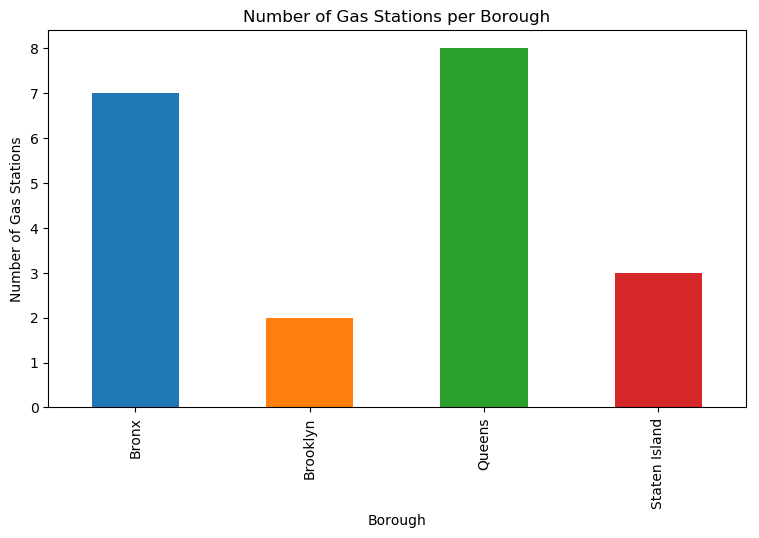

In [15]:
# Generating a plot for number of Gas Stations per Borough
 
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Gas Stations per Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 10)
#On y-axis
plt.ylabel('Number of Gas Stations', fontsize=10)
#giving a bar plot
list_of_venues.groupby('Borough')['ID'].count().plot(kind='bar')
#displays the plot
plt.show()

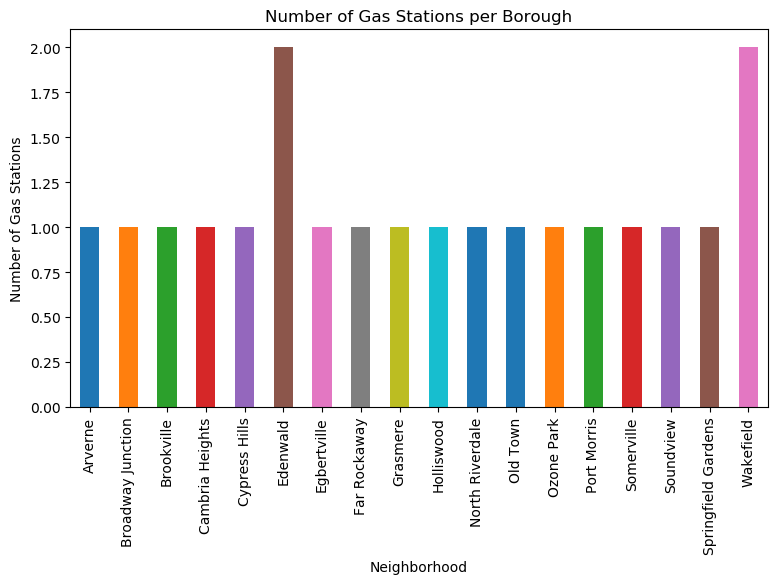

In [16]:
# Generating a Plot for number of Gas Stations per Neighborhood
 
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Gas Stations per Borough')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 10)
#On y-axis
plt.ylabel('Number of Gas Stations', fontsize=10)
#giving a bar plot
list_of_venues.groupby('Neighborhood')['ID'].count().plot(kind='bar')
#displays the plot
plt.show()

In [17]:
#Searching for an average Rating, Likes and Tips

column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
list_of_venues_satisfaction=pd.DataFrame(columns=column_names)

for row in list_of_venues.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_details(ID)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        id,name,likes,rating,tips=[0]*5
    list_of_venues_satisfaction = list_of_venues_satisfaction.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    
list_of_venues_satisfaction

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Wakefield,4c81a91c51ada1cd87741510,Shell,2,6.2,0
1,Bronx,Wakefield,59ea0da7872f7d28f0f4f428,Shell,1,6.0,1
2,Bronx,Port Morris,58014a9ed67c3b6b40463cdc,Shell,1,6.0,0
3,Bronx,Soundview,4cc9a05d4650a35da6998f1e,Shell,2,6.2,1
4,Bronx,North Riverdale,4cd2f110fa66236a16f0ed2e,Shell,4,6.2,2
5,Bronx,Edenwald,4cd49e342944b1f7623458ec,Shell,0,5.9,0
6,Bronx,Edenwald,59ea0da7872f7d28f0f4f428,Shell,1,6.0,1
7,Brooklyn,Cypress Hills,4c31eaee16adc928663ec19c,Shell,0,5.6,0
8,Queens,Ozone Park,4b5f6efcf964a52007ba29e3,Speedway,13,6.7,3
9,Queens,Springfield Gardens,4bc513a36a3e9c745075f548,Shell,3,5.6,5


In [18]:
#Creating a list of 6 neighborhoods with the lowest average rating for gas station services

list_of_venues_satisfaction['Likes']=list_of_venues_satisfaction['Likes'].astype('float64')
list_of_venues_satisfaction['Tips']=list_of_venues_satisfaction['Tips'].astype('float64')

neighborhood_target=list_of_venues_satisfaction.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
neighborhood_target.columns=['Neighborhood','Average Rating']

neighborhood_target.sort_values(['Average Rating'],ascending=False).tail(6)

,Neighborhood,Average Rating
7,Far Rockaway,5.9
1,Broadway Junction,5.9
6,Egbertville,5.9
4,Cypress Hills,5.6
2,Brookville,5.6
16,Springfield Gardens,5.6


In [19]:
neighborhood_target_found=neighborhood_target[neighborhood_target['Average Rating']<=5.9]

In [20]:
#Merging Geo Data with our target Neighborhoods

neighborhood_target_found=pd.merge(new_york, neighborhood_target_found, on='Neighborhood')
neighborhood_target_found=neighborhood_target_found[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

neighborhood_target_found

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Cypress Hills,40.682391,-73.876616,5.6
1,Queens,Springfield Gardens,40.666230,-73.760421,5.6
2,Queens,Far Rockaway,40.603134,-73.754980,5.9
3,Queens,Brookville,40.660003,-73.751753,5.6
4,Brooklyn,Broadway Junction,40.677861,-73.903317,5.9
5,Staten Island,Egbertville,40.579119,-74.127272,5.9


In [21]:
# Generating map with Folium

gas_stations_map = folium.Map(location=geo_location('New York City'), zoom_start=10)

incidents = folium.map.FeatureGroup()
for lat, lng, in neighborhood_target_found[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=20, 
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.5
        )
    )
    
neighborhood_target_found['Label']=neighborhood_target_found['Neighborhood']+', '+neighborhood_target_found['Borough']+'('+neighborhood_target_found['Average Rating'].map(str)+')'

# add pop-up text to each marker on the map
for lat, lng, label in neighborhood_target_found[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(gas_stations_map)        
# add incidents to map
gas_stations_map.add_child(incidents)

40.7127281 -74.0060152
